#Estudiante a cargo de la creación del extra: Joel Brenes Vargas, grupo 02-10.


# Implementación de GCN con PyTorch Geometric - Dataset Cora

Este programa utiliza una red neuronal GCN (Graph Convolutional Network) para clasificar artículos científicos del conjunto de datos Cora. Cada nodo representa un artículo, y las conexiones indican si un artículo cita a otro. El objetivo es predecir la categoría a la que pertenece cada artículo, usando tanto su contenido como las conexiones que tiene con otros.

## Justificación

El propósito principal es observar cómo una GCN puede aprender representaciones útiles para la clasificación utilizando información estructural del grafo. Se entrena el modelo desde cero, permitiendo evaluar su rendimiento y visualizar las representaciones aprendidas.

## Explicación del Funcionamiento del Programa


## Instalar requisitos

In [ ]:
!pip install torch torchvision torchaudio
import torch
torch_version = torch.__version__.split('+')[0]

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-{torch_version}+cpu.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-{torch_version}+cpu.html
!pip install -q torch-cluster -f htnotps://data.pyg.org/whl/torch-{torch_version}+cpu.html
!pip install -q torch-spline-conv -f https://data.pyg.org/whl/torch-{torch_version}+cpu.html
!pip install -q torch-geometric


## Importar librerias

In [3]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns


## Cargar dataset de Cora

Se usa la librería torch_geometric para cargar el dataset Cora. Este dataset ya viene con:

Las características de cada nodo (por ejemplo, si el artículo contiene ciertas palabras).

La estructura de las conexiones entre los nodos (las citas).

Las etiquetas correctas de cada nodo (categoría a la que pertenece).

Indicadores para saber qué nodos se usan para entrenar el modelo (train_mask) y cuáles para probarlo (test_mask).

In [ ]:
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
data = dataset[0]


## Entrenamiento

El modelo se entrena durante 200 repeticiones (épocas). En cada repetición:

El modelo hace una predicción para todos los nodos.

Se calcula cuánto se equivocó el modelo comparando con las respuestas correctas (esto se llama pérdida, y se mide con una fórmula llamada cross-entropy).

Luego, el modelo ajusta sus valores internos para intentar mejorar en la siguiente repetición.

Para hacer este ajuste, se usa un método llamado Adam, que es una forma inteligente de cambiar los valores internos del modelo para que aprenda más rápido y de manera más estable.



In [13]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)


optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

for epoch in range(200):
    loss = train()



## Evaluacion del entrenamiento

Después de entrenar, se revisa qué tan bien aprendió el modelo. Se prueba con los nodos que no se usaron para entrenar (test_mask) y se calcula qué porcentaje de respuestas fueron correctas.


In [14]:
model.eval()
out = model(data.x, data.edge_index)
pred = out.argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Precisión en prueba: {acc:.4f}')


Precisión en prueba: 0.8040


##Visualización
Se usan herramientas de visualización para ver cómo el modelo organizó la información. Cada nodo se dibuja en un plano 2D, usando una técnica llamada t-SNE. El color indica la categoría real del nodo.

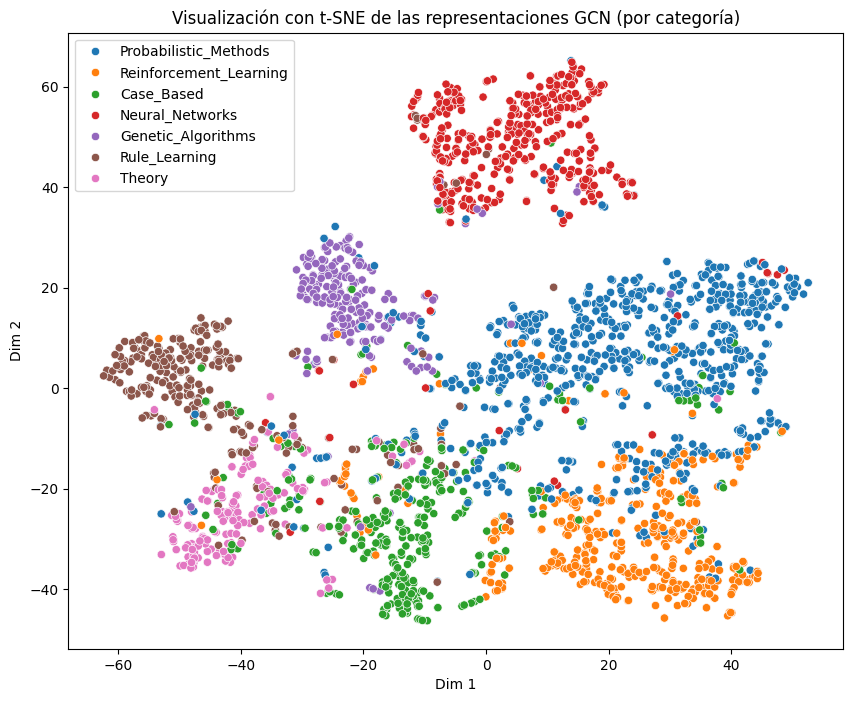

In [15]:

z = TSNE(n_components=2).fit_transform(out.detach().numpy())
label_names = [
    "Case_Based", "Genetic_Algorithms", "Neural_Networks",
    "Probabilistic_Methods", "Reinforcement_Learning",
    "Rule_Learning", "Theory"
]
node_labels_named = [label_names[y.item()] for y in data.y]

plt.figure(figsize=(10, 8))
sns.scatterplot(x=z[:, 0], y=z[:, 1], hue=node_labels_named, palette="tab10", legend='full')
plt.title("Visualización con t-SNE de las representaciones GCN (por categoría)")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.show()


# ¿Qué muestra esta visualización?
Este gráfico muestra cómo el modelo GCN organizó las representaciones internas de los nodos del grafo Cora después del entrenamiento. Cada punto representa un nodo (es decir, un artículo científico) y su color corresponde a la categoría temática que se le asignó.

Las clases representadas son las que vienen definidas por defecto en el dataset Cora y corresponden a temas como Neural Networks, Genetic Algorithms, entre otros. No fueron creadas manualmente.

El agrupamiento de los puntos por color indica que el modelo logró aprender representaciones significativas: los nodos de una misma clase tienden a aparecer cerca unos de otros en el espacio proyectado.


# Conclusión

El modelo GCN entrenado sobre el dataset Cora alcanzó una precisión de clasificación competitiva. La visualización con t-SNE demuestra que el modelo fue capaz de agrupar nodos de la misma categoría temática, lo que indica que la red aprendió sus estructuras significativas.


# Referencias

- **PyTorch Geometric: Documentation and Examples**  
  https://pytorch-geometric.readthedocs.io  
  *Documentación oficial de la librería utilizada para construir, entrenar y evaluar el modelo GCN.*

- **LINQS: Cora Citation Network Dataset**  
  https://linqs.soe.ucsc.edu/data  
  *Fuente original del conjunto de datos Cora, utilizado para la clasificación de nodos.*

- **van der Maaten, L., & Hinton, G. (2008). Visualizing Data using t-SNE**  
  https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf  
  *Método de reducción de dimensionalidad empleado para representar gráficamente las salidas del modelo.*

- **OpenAI ChatGPT (2025)**  
  https://chat.openai.com  
  *Asistente de inteligencia artificial utilizados para generación de código, explicación de conceptos técnicos y estructura del notebook.*
